# Goal

* visualizing and exploring the existence of function groups defined by incorporator status 
  * incorporator status (binary: yes/no)
  * just incorporators, but all times/treatments
* clustering:
  * PAM 
  * random forest?
  * SOM?
* ordination methods
  * PCA 
  * t-SNE (jaccard distance)
  * PCoA (jaccard distance)
  * nmds (jaccard distance)

# Setting variables

In [1]:
import os
%load_ext rpy2.ipython
%load_ext pushnote

In [3]:
%%R
workDir = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/incorporators/l2fc_heavy_window/incorp_ordi_clust/'
figDir = '/home/nick/notebook/fullCyc/figures/incorporators/incorp_PCA_clust/'

# physeq
physeqDir = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/phyloseq/'
physeqBulk = 'bulk-norm-core' 

# log2 fold change
l2fcResDir = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/incorporators/l2fc_heavy_window/'
l2fcResFile = file.path(l2fcResDir, 'l2fc_sparse-maxRejH.txt')


# params
padj.cutoff = 0.05   # adjusted p-value cutoff for selecting incorporators
nprocs = 24

# Init

In [4]:
%Rpull workDir
workDir = workDir[0]
if not os.path.isdir(workDir):
    os.makedirs(workDir)
    
%cd $workDir    

/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/incorporators/l2fc_heavy_window/incorp_PCA_clust


In [77]:
%%R
library(phyloseq)
library(dplyr)
library(tidyr)
library(ggplot2)
library(vegan)
library(MASS)
library(NbClust)
library(cluster)

# Loading files

In [6]:
%%R 
# log2 fold change analysis results file
df.l2fc = read.delim(l2fcResFile, sep='\t') %>%
    mutate(Rank2 = gsub('^__', '', Rank2),
           Rank3 = gsub('^__', '', Rank3),
           Rank4 = gsub('^__', '', Rank4),
           Rank5 = gsub('^__', '', Rank5),
           Rank6 = gsub('^__', '', Rank6),
           Rank7 = gsub('^__', '', Rank7))
df.l2fc %>% head(n=3)

  Substrate Day Microcosm_replicate sparsity_threshold      OTU log2FoldChange
1   13C-Ami   1                   2               0.25  OTU.514    -0.67802374
2   13C-Ami   1                   2               0.25  OTU.816    -0.06751225
3   13C-Ami   1                   2               0.25 OTU.1099    -0.01965210
          p padj    Rank1          Rank2               Rank3
1 0.9999869    1 Bacteria Proteobacteria Deltaproteobacteria
2 0.9839460    1 Bacteria Proteobacteria Deltaproteobacteria
3 0.9867221    1 Bacteria  Acidobacteria               32-21
                 Rank4          Rank5      Rank6                Rank7 Rank8
1    Desulfobacterales Nitrospinaceae uncultured uncultured_bacterium  <NA>
2    Desulfobacterales Nitrospinaceae uncultured uncultured_bacterium  <NA>
3 uncultured_bacterium           <NA>       <NA>                 <NA>  <NA>


# Selecting incorporators

In [7]:
%%R

df.inc = df.l2fc %>%
    filter(padj < padj.cutoff)

cat('Total number of incorporator OTUs:', df.inc$OTU %>% unique %>% length, '\n')

Total number of incorporator OTUs: 418 


In [8]:
%%R
df.l2fc = df.l2fc %>% 
    mutate(Incorporator = (padj < padj.cutoff) %>% as.numeric) 
df.l2fc %>% head(n=3)

  Substrate Day Microcosm_replicate sparsity_threshold      OTU log2FoldChange
1   13C-Ami   1                   2               0.25  OTU.514    -0.67802374
2   13C-Ami   1                   2               0.25  OTU.816    -0.06751225
3   13C-Ami   1                   2               0.25 OTU.1099    -0.01965210
          p padj    Rank1          Rank2               Rank3
1 0.9999869    1 Bacteria Proteobacteria Deltaproteobacteria
2 0.9839460    1 Bacteria Proteobacteria Deltaproteobacteria
3 0.9867221    1 Bacteria  Acidobacteria               32-21
                 Rank4          Rank5      Rank6                Rank7 Rank8
1    Desulfobacterales Nitrospinaceae uncultured uncultured_bacterium  <NA>
2    Desulfobacterales Nitrospinaceae uncultured uncultured_bacterium  <NA>
3 uncultured_bacterium           <NA>       <NA>                 <NA>  <NA>
  Incorporator
1            0
2            0
3            0


# Incorp matrix

In [10]:
%%R 
# selecting all incorporator OTUs, keeping l2fc values for all substrates/days

cat('Total number of incorporator OTUs:', df.inc$OTU %>% unique %>% length, '\n')

df.inc = df.l2fc %>%
    filter(OTU %in% df.inc$OTU) %>%
    unite(Substrate_Day, Substrate, Day, sep='_') %>%
    dplyr::select(OTU, Substrate_Day, Incorporator) %>%
    spread(Substrate_Day, Incorporator, fill=0) 
rownames(df.inc) = df.inc$OTU
df.inc$OTU = NULL

df.inc %>% nrow %>% print
df.inc %>% head(n=3)

Total number of incorporator OTUs: 418 
[1] 418
          13C-Ami_1 13C-Ami_14 13C-Ami_3 13C-Ami_6 13C-Cel_14 13C-Cel_3
OTU.1             0          0         0         0          0         0
OTU.10019         0          0         0         0          1         0
OTU.1002          0          0         0         0          0         0
          13C-Cel_30 13C-Cel_48 13C-Cel_6 13C-Glu_1 13C-Glu_14 13C-Glu_3
OTU.1              0          0         0         0          0         0
OTU.10019          0          0         0         0          0         0
OTU.1002           1          0         0         0          0         0
          13C-Glu_6 13C-Gly_1 13C-Gly_14 13C-Gly_3 13C-Gly_6 13C-Lac_1
OTU.1             0         0          0         0         0         0
OTU.10019         0         0          0         0         0         0
OTU.1002          0         0          0         0         0         0
          13C-Lac_3 13C-Lac_6 13C-Oxa_14 13C-Oxa_3 13C-Oxa_6 13C-Pal_14
OTU.1           

In [75]:
%%R
# 
table(apply(df.inc, 1, sum))


  1   2   3   4   5   6   7   8   9  13  14 
250  93  39  17   7   5   2   1   2   1   1 


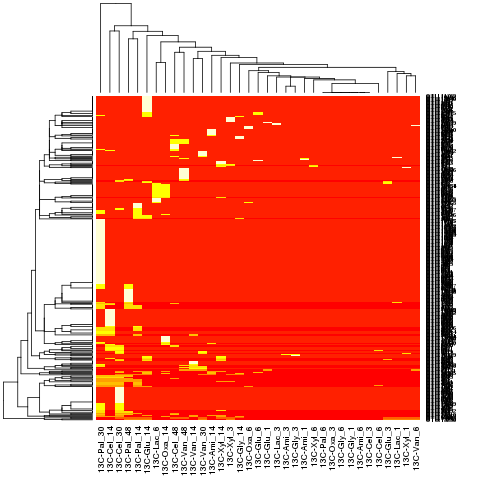

In [13]:
%%R
# check of incorporator status matrix
heatmap(df.inc %>% as.matrix)

# Clustering

## NbClust 

In [ ]:
%%R -w 800 -h 300

idxs = c("kl", "ch", "hartigan", "ccc", "scott", "marriot", "trcovw",
          "tracew", "friedman", "rubin", "cindex", "db", "silhouette",
          "duda", "pseudot2", "beale", "ratkowsky", "ball",
          "ptbiserial", "gap", "frey", "mcclain", "gamma", "gplus",
          "tau", "dunn", "hubert", "sdindex", "dindex", "sdbw")

idxs = c("kl", "ch", "hartigan", "cindex", "db", "silhouette",
          "duda", "pseudot2", "beale", "ratkowsky", "ball", "gap",
          "ptbiserial", "frey", "mcclain", "dunn", "sdindex", "sdbw")


nbc.res = list()
for (idx in idxs){
    nbc.res[[idx]] = NbClust(df.inc, distance='binary', method='average', index=idx, min.nc=2, max.nc=150)
    }

In [116]:
%%R

df.nbc = do.call(rbind, lapply(nbc.res, function(x) x$Best.nc)) %>%
        as.data.frame
df.nbc

           Number_clusters Value_Index
kl                     119         Inf
ch                     119         Inf
hartigan               118         Inf
cindex                 119      0.0000
db                     119      0.0000
silhouette             119      1.0000
duda                     2      0.9967
pseudot2                 2      1.3507
beale                    2      0.0806
ratkowsky             -Inf      0.0000
ball                     3    105.9756
gap                      2     -0.8400
ptbiserial              76      0.8292
frey                     1          NA
mcclain                119      0.0000
dunn                   119         Inf
sdindex                  2         Inf
sdbw                   119      0.0000


In [119]:
%%R
n.clust = df.nbc$Number_clusters %>% table 
n = df.nbc %>% nrow
n.clust / n

.
      -Inf          1          2          3         76        118        119 
0.05555556 0.05555556 0.27777778 0.05555556 0.05555556 0.05555556 0.44444444 


#### Notes

* 50% of tests indicate best number of clusters = 119 (or 118)
* 2 clusters was 2nd best choice 

## PAM

k with the max mean silho score: 117 


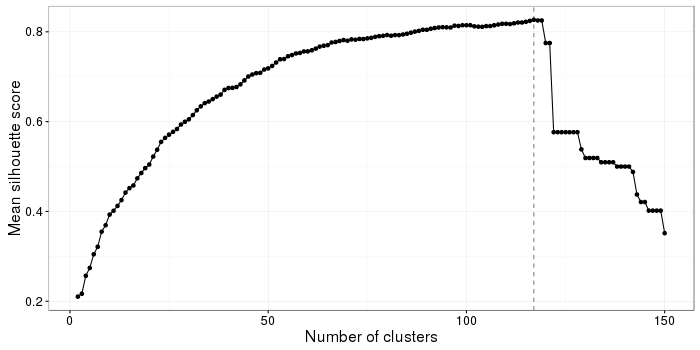

In [72]:
%%R -w 700 -h 350
# finding k with largest overall average silhouette width
ks = seq(2,150)

mean_silhouette = function(k, mtx){
    pam.res = pam(mtx, k)
    return(pam.res$silinfo$avg.width)
}

# calculating 
mean_silho = sapply(ks, mean_silhouette, mtx=df.inc)
df.silho = data.frame('k' = ks, 'mean_silho' = mean_silho)

# k with max silho score
max.k = df.silho[df.silho$mean_silho == max(df.silho$mean_silho),'k'][1]
cat('k with the max mean silho score:', max.k, '\n')

# plotting
ggplot(df.silho, aes(k, mean_silho)) +
    geom_point() +
    geom_line() +
    geom_vline(xintercept=max.k, linetype='dashed', alpha=0.5) +
    labs(x='Number of clusters', y='Mean silhouette score') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

k with the max mean silho score: 109 


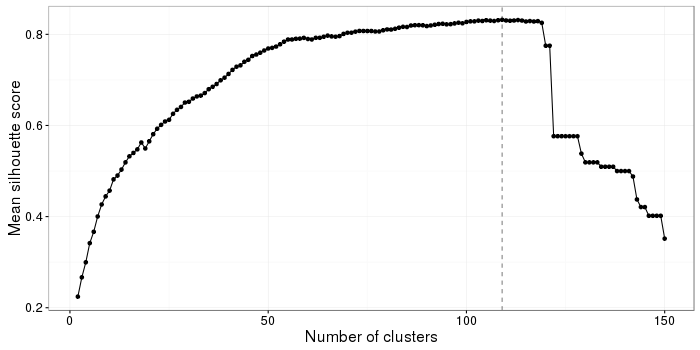

In [73]:
%%R -w 700 -h 350
# finding k with largest overall average silhouette width
ks = seq(2,150)

mean_silhouette = function(k, mtx){
    jac = vegdist(mtx, method='jaccard')
    pam.res = pam(jac, k)
    return(pam.res$silinfo$avg.width)
}

# calculating 
mean_silho = sapply(ks, mean_silhouette, mtx=df.inc)
df.silho = data.frame('k' = ks, 'mean_silho' = mean_silho)

# k with max silho score
max.k = df.silho[df.silho$mean_silho == max(df.silho$mean_silho),'k'][1]
cat('k with the max mean silho score:', max.k, '\n')

# plotting
ggplot(df.silho, aes(k, mean_silho)) +
    geom_point() +
    geom_line() +
    geom_vline(xintercept=max.k, linetype='dashed', alpha=0.5) +
    labs(x='Number of clusters', y='Mean silhouette score') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

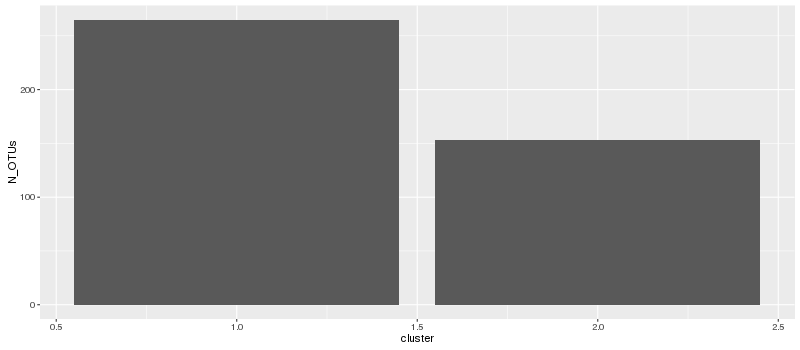

In [184]:
%%R -w 800 -h 350

k = 2
pam.res = pam(df.inc, k)

df.pam.res.s = pam.res$cluster %>% table %>% as.data.frame
colnames(df.pam.res.s) = c('cluster', 'N_OTUs')
df.pam.res.s$cluster = df.pam.res.s$cluster %>% as.numeric

ggplot(df.pam.res.s, aes(cluster, N_OTUs)) +
    geom_bar(stat='identity')

# Ordination

## PCA on incorporator matrix

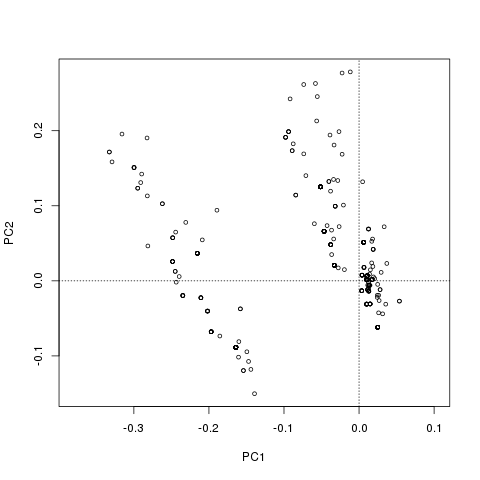

In [185]:
%%R
pca.inc = rda(df.inc %>% t)
plot(pca.inc, display='species')

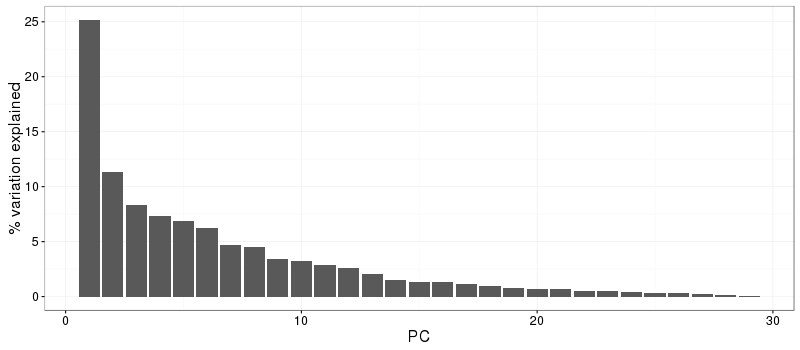

In [186]:
%%R -w 800 -h 350
df.pca.inc.eig = pca.inc$CA$eig %>% as.data.frame
df.pca.inc.eig$PC = gsub('PC', '', rownames(df.pca.inc.eig)) %>% as.numeric
colnames(df.pca.inc.eig) = c('value', 'PC')
df.pca.inc.eig = df.pca.inc.eig %>%
    group_by() %>%
    mutate(PC_perc = value / sum(value) * 100) %>%
    ungroup()


ggplot(df.pca.inc.eig, aes(PC, PC_perc)) +
    geom_bar(stat='identity') +
    labs(x='PC', y='% variation explained') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

In [187]:
%%R
df.pam.clst = pam.res$clustering %>% as.data.frame
colnames(df.pam.clst) = c('cluster')
df.pam.clst$OTU = rownames(df.pam.clst)
rownames(df.pam.clst) = 1:nrow(df.pam.clst)
df.pam.clst$cluster = df.pam.clst$cluster %>% as.character
df.pam.clst %>% head

  cluster       OTU
1       1     OTU.1
2       1 OTU.10019
3       1  OTU.1002
4       1  OTU.1004
5       2  OTU.1008
6       1  OTU.1016


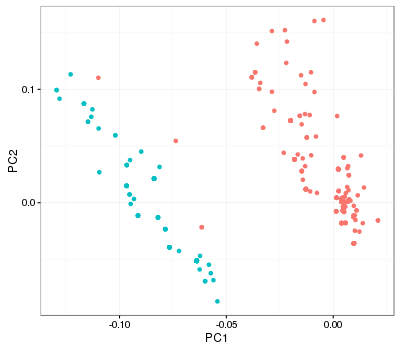

In [188]:
%%R -h 350 -w 400

df.pca.inc = pca.inc$CA$v %>%
    as.data.frame() %>%
    dplyr::select(PC1, PC2) 
df.pca.inc$OTU = rownames(df.pca.inc)

df.pca.inc = inner_join(df.pca.inc, df.pam.clst, c('OTU' = 'OTU'))

ggplot(df.pca.inc, aes(PC1, PC2, color=cluster)) +
    geom_point() +
    theme_bw() +
    theme(
        legend.position='none'
    )

### l2fc patterns for each group

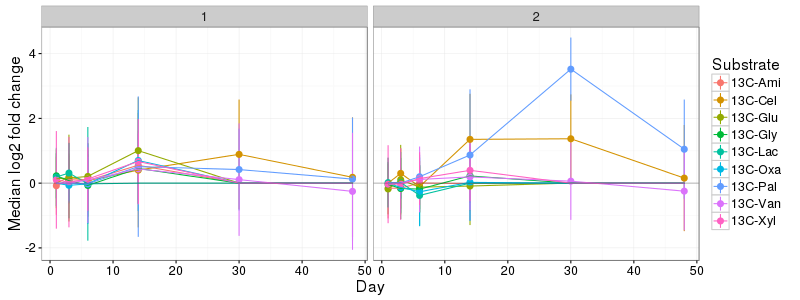

In [215]:
%%R -w 800 -h 300

df.l2fc.j = inner_join(df.l2fc, df.pca.inc, c('OTU' = 'OTU'))


df.l2fc.j.s = df.l2fc.j %>%
    group_by(Substrate, Day, cluster) %>%
    summarize(median_l2fc = median(log2FoldChange),
              stdev_l2fc = sd(log2FoldChange),
              stderr_l2fc = sd(log2FoldChange)/sqrt(n())) %>%
    ungroup() %>%
    complete(Substrate, Day, cluster) %>%
    mutate(median_l2fc = ifelse(is.na(median_l2fc), 0, median_l2fc))

ggplot(df.l2fc.j.s, aes(Day, median_l2fc, color=Substrate,
                        ymin=median_l2fc-stdev_l2fc,
                        ymax=median_l2fc+stdev_l2fc)) +
    geom_pointrange() +
    geom_line() +
    geom_hline(yintercept=0, alpha=0.25) +
    labs(y='Median log2 fold change') +
    facet_wrap(~ cluster) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

# t-SNE

In [216]:
%%R
tsne.res = tsne::tsne(df.inc)
saveRDS(tsne.res, 'tsne_inc')

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Epoch: Iteration #100 error is: 12.0415690407976

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Epoch: Iteration #200 error is: 0.415889238046384

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Epoch: Iteration #300 error is: 0.572127931505041

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Epoch: Iteration #400 error is: 0.61054936136427

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Epoch: Iteration #500 error is: 0.625589947296804

  res = super(Function, self).__call__(*new_args, **new_

In [217]:
%%R
# formatting tSNE output
df.tsne.res = readRDS('tsne_inc') %>% as.data.frame
colnames(df.tsne.res) = c('tsne_axis1', 'tsne_axis2')
#df.tsne.res = as.data.frame(tsne.res)
df.tsne.res$OTU = rownames(df.inc)
df.tsne.res = inner_join(df.tsne.res, df.pam.clst, c('OTU' = 'OTU'))
df.tsne.res %>% head

  tsne_axis1 tsne_axis2       OTU cluster
1   17.91424   38.56441     OTU.1       1
2  -70.61981  -19.64854 OTU.10019       1
3   49.95089   29.00696  OTU.1002       1
4  -72.67133  -35.90755  OTU.1004       1
5  -31.86797   27.43637  OTU.1008       2
6   61.69509  -21.87783  OTU.1016       1


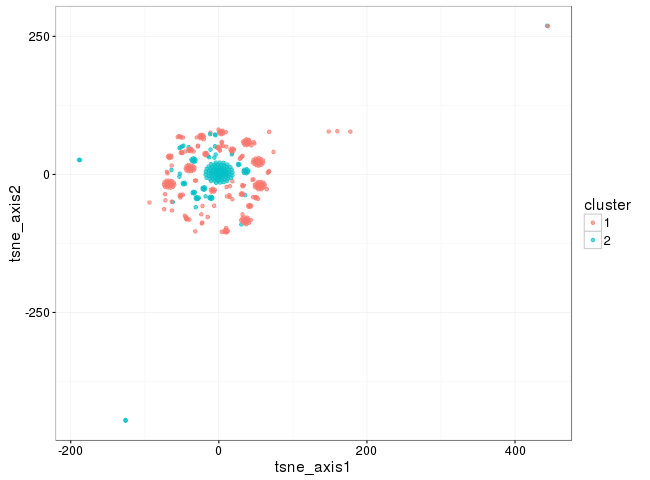

In [218]:
%%R -w 650

ggplot(df.tsne.res, aes(tsne_axis1, tsne_axis2, color=cluster)) +
    geom_point(alpha=0.65) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

## Jaccard distance matrix

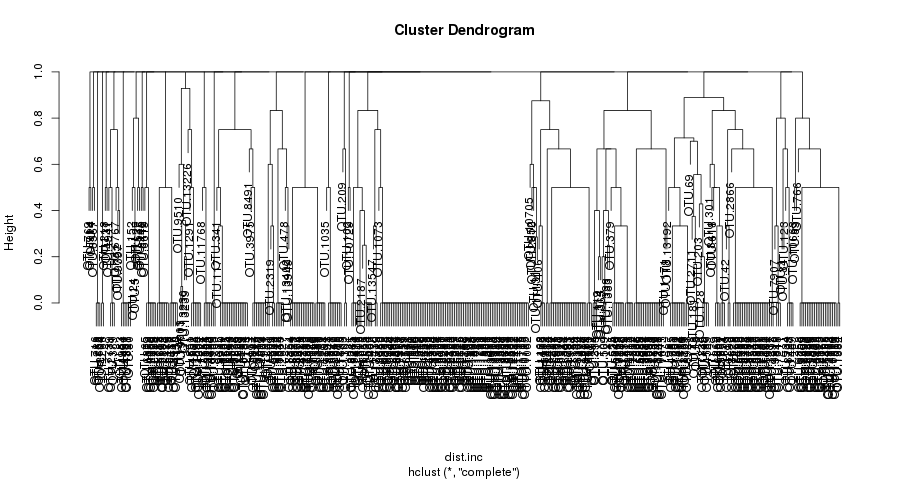

In [26]:
%%R -w 900

dist.inc = vegdist(df.inc, method='jaccard')
plot(hclust(dist.inc))

In [219]:
%%R
dist.inc = vegdist(df.inc, method='jaccard')
tsne.res = tsne::tsne(dist.inc)
saveRDS(tsne.res, 'tsne_inc_jacc')

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Epoch: Iteration #100 error is: 11.5795632253211

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Epoch: Iteration #200 error is: 0.407963876154273

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Epoch: Iteration #300 error is: 0.477613811317656

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Epoch: Iteration #400 error is: 0.55033619271008

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Epoch: Iteration #500 error is: 0.587462841698427

  res = super(Function, self).__call__(*new_args, **new_

In [220]:
%%R
# formatting tSNE output
df.tsne.res = readRDS('tsne_inc_jacc') %>% as.data.frame
colnames(df.tsne.res) = c('tsne_axis1', 'tsne_axis2')
#df.tsne.res = as.data.frame(tsne.res)
df.tsne.res$OTU = rownames(df.inc)
df.tsne.res = inner_join(df.tsne.res, df.pam.clst, c('OTU' = 'OTU'))
df.tsne.res %>% head

  tsne_axis1 tsne_axis2       OTU cluster
1 -10.560443  56.673413     OTU.1       1
2  59.167242  36.653061 OTU.10019       1
3  43.493587  -2.760032  OTU.1002       1
4  -1.569000 -19.229274  OTU.1004       1
5   6.800184   4.775736  OTU.1008       2
6  -7.641399 -57.790802  OTU.1016       1


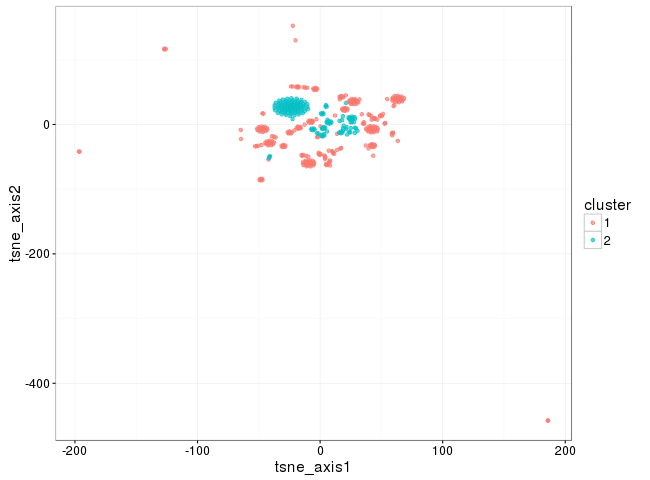

In [221]:
%%R -w 650

ggplot(df.tsne.res, aes(tsne_axis1, tsne_axis2, color=cluster)) +
    geom_point(alpha=0.65) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

## PCoA

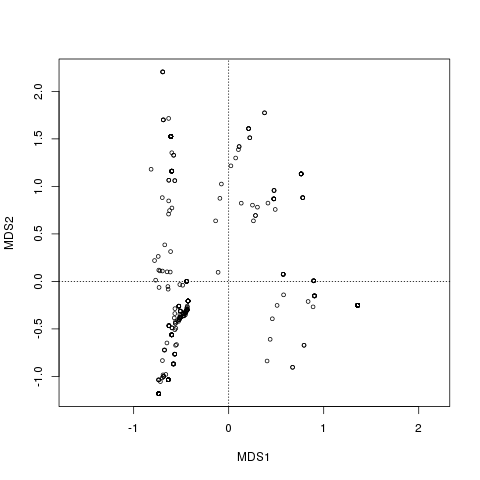

In [240]:
%%R 

dist.inc = vegdist(df.inc, method='jaccard')
pcoa.dist.inc = capscale(dist.inc ~ 1)
plot(pcoa.dist.inc)

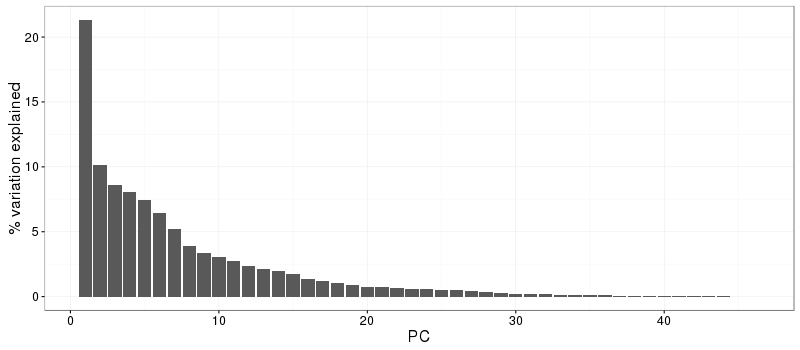

In [241]:
%%R -w 800 -h 350
pcoa.dist.inc.eig = pcoa.dist.inc$CA$eig %>% as.data.frame
pcoa.dist.inc.eig$PC = gsub('MDS', '', rownames(pcoa.dist.inc.eig)) %>% as.numeric
colnames(pcoa.dist.inc.eig) = c('value', 'MDS')
pcoa.dist.inc.eig = pcoa.dist.inc.eig %>%
    group_by() %>%
    mutate(MDS_perc = value / sum(value) * 100) %>%
    ungroup()

ggplot(pcoa.dist.inc.eig, aes(MDS, MDS_perc)) +
    geom_bar(stat='identity') +
    labs(x='PC', y='% variation explained') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

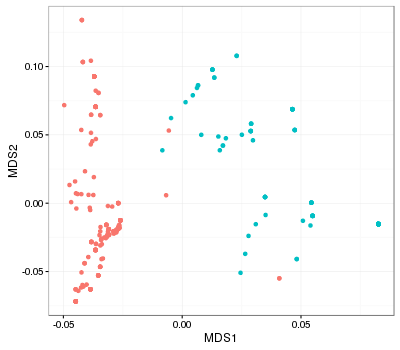

In [249]:
%%R -h 350 -w 400

df.pcoa.dist.inc = pcoa.dist.inc$CA$u %>%
    as.data.frame() %>%
    dplyr::select(MDS1, MDS2) 
df.pcoa.dist.inc$OTU = rownames(df.pcoa.dist.inc)

df.pcoa.dist.inc = inner_join(df.pcoa.dist.inc, df.pam.clst, c('OTU' = 'OTU'))

ggplot(df.pcoa.dist.inc, aes(MDS1, MDS2, color=cluster)) +
   geom_point() +
   theme_bw() +
   theme(
       legend.position='none'
   )